<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/AutoencoderBasico_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nos descargamos las imágenes con un ancho de 256 de ancho. Vamos a ir escalando a 64, 128 y 256. Lo haremos con cv2.resize()

In [3]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-22 15:06:11 URL:https://uc6db497859daa9fe62fb63539da.dl.dropboxusercontent.com/cd/0/inline2/BnuU0v9LNVVCkAhUaxI_i8zw3aZdtoEGQF4tcyZk6y4CUgA00Fc1orwN-oTTi3oyCThXr1QptrJMqUrFb2jP5zFg9cKfZBiwjL_3G5yvHAo1DxwBeci27E5TsLGB5FJE6lFgXrGzUJoP2C4J4yN0a-lMlm5UPLrY5czqNy6GMlY9PhkBHhJDSW8eQODXgtu6EVlHImwrlqktuyOW3r4kOLf2cGyZaTm53HZRUWbXKaiVj0_CZHtVqUmaulhPhWDCYJIdPrd9L4-0zA95Tc0FqCGIEe0bK9Vt5dBJ2H0YtHF7H2rL4A-75n3qi49P23eeB0Gb0W5X8vQwErrWHb0LX0gvi35t16nd6G0a1qnuIJpyyhYR_GwBt9rw1eQEAYfOX8qRL-7sjxpjb2AB4k1mxLBBlgiMvf6twLM0-XabTbMK5A/file [138777773/138777773] -> "train.zip" [1]
2022-06-22 15:06:13 URL:https://uc051d18d5dde9774d1fdda2269f.dl.dropboxusercontent.com/cd/0/inline2/BnsH9ViTiS2RN4yKQI2QOa7kAZvsHb8M9m7OLqulAV0XkisdHroCc2Qh62jSnTZb38G9Qr8BOhoyq9Go49oupfORWQ-sHXudO2YFb92S0iFIeoF7Pv49Bh12wcLpsFGpbz4Z3qWLyvMsH7RguJWs4vpyOqRfFVdtmd9SSnF06LzT1mT8qL5g1OtRhI13PJwfNLa3GVvXIINWSnb14GkXtrrTXSwT_TrI3qAih-uGEx-TOjHMGzCz0OskvuMrSrV3Q86Vov7TaO9LPUITdk7-uibupKTJ_stZA7bvHRlSMep9BeRnYJkeu_qKeEcI64-vjx4

In [9]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

replace Training_Set_Pre/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace Test_Set_Pre/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace Evaluation_Set_Pre/val.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Librerías

In [1]:
import PIL
import cv2
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
trainPath = 'Training_Set_Pre/'
testPath  = 'Test_Set_Pre/'
valPath  =  'Evaluation_Set_Pre/'

In [3]:
import shutil

def getNpArray(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    image = cv2.imread(pathO + '/' + str(id) + '.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    if(int(enf)==0):
      normal.append(np.asarray(image))
    else:
      enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [4]:
df_train = pd.read_csv(trainPath + '/train.csv')
df_test = pd.read_csv(testPath + '/test.csv')
df_val = pd.read_csv(valPath + '/val.csv')

### Crear Arrays

In [16]:
IMG_SIZE = 64

In [17]:
normalTrain, enfermedadTrain = getNpArray(df_train, trainPath + 'Training/')
normalTest, enfermedadTest = getNpArray(df_test, testPath + 'Test/')
normalVal, enfermedadVal = getNpArray(df_val, valPath + 'Validation/')

In [18]:
normalTrain.shape

(401, 64, 64, 3)

In [19]:
normalTest.shape

(134, 64, 64, 3)

Ya la tenemos reescalada a la medida deseada:

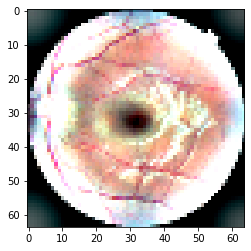

In [20]:
plt.imshow(normalTrain[0])

## Autoencoder

In [21]:
input_img = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))

### Encoder

In [22]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# Capa de max pooling con filtro de tamaño 2x2 y aplicando padding
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

### Decoder

In [23]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
 # Capa de upsampling con filtro de tamaño 2x2 y aplicando padding
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [24]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [25]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248

### Entrenamiento

In [26]:
autoencoder.fit(normalTrain, normalTrain,
                epochs=20,
                batch_size=128,
                validation_data=(normalVal, normalVal))

Epoch 1/20
4/4 [==============================] - 2s 144ms/step - loss: -4837.1328 - val_loss: -23474.6504
Epoch 2/20
4/4 [==============================] - 0s 31ms/step - loss: -42318.1914 - val_loss: -121628.4062
Epoch 3/20
4/4 [==============================] - 0s 33ms/step - loss: -192890.7500 - val_loss: -477890.9062
Epoch 4/20
4/4 [==============================] - 0s 32ms/step - loss: -711793.6875 - val_loss: -1561362.0000
Epoch 5/20
4/4 [==============================] - 0s 31ms/step - loss: -2210672.7500 - val_loss: -4452825.0000
Epoch 6/20
4/4 [==============================] - 0s 31ms/step - loss: -6114876.5000 - val_loss: -11589174.0000
Epoch 7/20
4/4 [==============================] - 0s 31ms/step - loss: -15527732.0000 - val_loss: -27871500.0000
Epoch 8/20
4/4 [==============================] - 0s 30ms/step - loss: -36399632.0000 - val_loss: -62360252.0000
Epoch 9/20
4/4 [==============================] - 0s 32ms/step - loss: -79744792.0000 - val_loss: -130896776.0000
Epo

### Pruebas

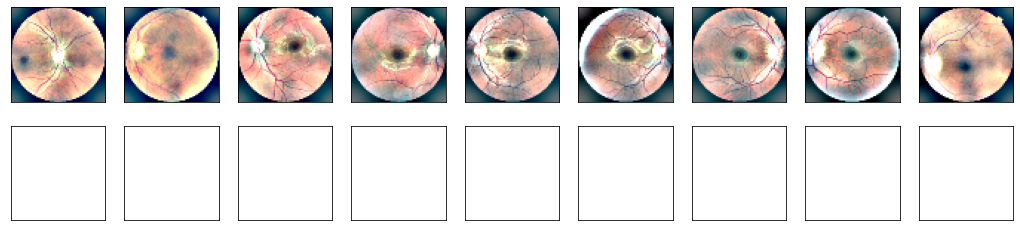

In [27]:
decoded_imgs = autoencoder.predict(normalTest)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    ax = plt.subplot(2, n, i)
    plt.imshow(normalTest[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

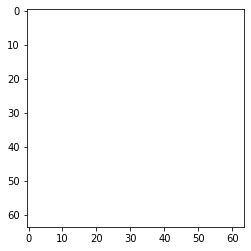

In [28]:
plt.imshow(decoded_imgs[0])